In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import CLIPTokenizer, CLIPModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_fn(batch):
    images = []
    captions = []
    for img, caption_list in batch:
        images.append(img)
        # Pick the first caption from the list
        captions.append(caption_list[0])
    images = torch.stack(images, dim=0)
    return images, captions


image_dir = "train2017/train2017" 
ann_file = "annotations_trainval2017/annotations/captions_train2017.json" 

transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
coco_dataset = datasets.CocoCaptions(root=image_dir, annFile=ann_file, transform=transform)

print(f"Number of samples: {len(coco_dataset)}")
img, captions = coco_dataset[0]
print("Image tensor shape:", img.shape)
print("Captions:", captions)

c:\Users\DARSHAN SONAWANE\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


loading annotations into memory...
Done (t=0.72s)
creating index...
index created!
Number of samples: 118287
Image tensor shape: torch.Size([3, 64, 64])
Captions: ['Closeup of bins of food that include broccoli and bread.', 'A meal is presented in brightly colored plastic trays.', 'there are containers filled with different kinds of foods', 'Colorful dishes holding meat, vegetables, fruit, and bread.', 'A bunch of trays that have different food.']


In [ ]:
from transformers import CLIPTokenizer, CLIPModel

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_model.eval()

caption = "A cat sitting on a wooden bench."
inputs = tokenizer(captions, return_tensors="pt", padding=True, truncation=True)
inputs = {k: v.to(device) for k, v in inputs.items()} 
with torch.no_grad():
    text_embeddings = clip_model.get_text_features(**inputs)
print("CLIP text embedding shape:", text_embeddings.shape)

c:\Users\DARSHAN SONAWANE\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\DARSHAN SONAWANE\.cache\huggingface\hub\models--openai--clip-vit-base-patch32. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


CLIP text embedding shape: torch.Size([5, 512])


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Generator(nn.Module):
    def __init__(self, noise_dim=100, text_dim=512, base_channels=64):
        super(Generator, self).__init__()
        self.noise_dim = noise_dim
        self.text_dim = text_dim
        self.base_channels = base_channels
        self.fc = nn.Linear(noise_dim + text_dim, base_channels * 8 * 4 * 4)
        self.bn_fc = nn.BatchNorm1d(base_channels * 8 * 4 * 4)
        self.deconv1 = nn.ConvTranspose2d(base_channels * 8, base_channels * 4, kernel_size=4, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(base_channels * 4)
        self.deconv2 = nn.ConvTranspose2d(base_channels * 4, base_channels * 2, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(base_channels * 2)
        self.deconv3 = nn.ConvTranspose2d(base_channels * 2, base_channels, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(base_channels)
        self.deconv4 = nn.ConvTranspose2d(base_channels, 3, kernel_size=4, stride=2, padding=1)

    def forward(self, noise, text_emb):
        x = torch.cat([noise, text_emb], dim=1)
        x = self.fc(x)
        x = self.bn_fc(x)
        x = x.view(x.size(0), self.base_channels * 8, 4, 4)
        x = F.relu(self.bn1(self.deconv1(x)), inplace=True)
        x = F.relu(self.bn2(self.deconv2(x)), inplace=True)
        x = F.relu(self.bn3(self.deconv3(x)), inplace=True)
        x = torch.tanh(self.deconv4(x))
        return x

In [4]:
class Discriminator(nn.Module):
    def __init__(self, text_dim=512, base_channels=64):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, base_channels, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(base_channels, base_channels*2, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(base_channels*2)
        self.conv3 = nn.Conv2d(base_channels*2, base_channels*4, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(base_channels*4)
        self.conv4 = nn.Conv2d(base_channels*4, base_channels*8, kernel_size=4, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(base_channels*8)
        self.fc_img = nn.Linear(base_channels*8*4*4, base_channels*8)
        self.fc_text = nn.Linear(text_dim, base_channels*8)
        self.fc_final = nn.Linear(base_channels*8*2, 1)
        
    def forward(self, image, text_emb):
        x = F.leaky_relu(self.conv1(image), 0.2, inplace=True)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2, inplace=True)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2, inplace=True)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2, inplace=True)
        x = x.view(x.size(0), -1)
        img_feat = F.leaky_relu(self.fc_img(x), 0.2, inplace=True)
        text_feat = F.leaky_relu(self.fc_text(text_emb), 0.2, inplace=True)
        combined = torch.cat([img_feat, text_feat], dim=1)
        out = self.fc_final(combined)
        return out

In [ ]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
noise_dim = 100
text_emb_dim = 512
generator = Generator(noise_dim=noise_dim, text_dim=text_emb_dim).to(device)
discriminator = Discriminator(text_dim=text_emb_dim).to(device)


lr = 2e-4
beta1 = 0.5
g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

criterion = nn.BCEWithLogitsLoss()

generator.train()
discriminator.train()
clip_model.eval() 

num_epochs = 5
batch_size = 64
dataloader = DataLoader(coco_dataset, batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=collate_fn)

for epoch in range(num_epochs):
    for i, (real_images, captions) in enumerate(dataloader):
        real_images = real_images.to(device)
        inputs = tokenizer(captions, return_tensors="pt", padding=True, truncation=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            text_embeddings = clip_model.get_text_features(**inputs)
            
        real_labels = torch.full((real_images.size(0), 1), 0.9, device=device)
        fake_labels = torch.zeros(real_images.size(0), 1, device=device)  

        real_output = discriminator(real_images, text_embeddings)
        d_loss_real = criterion(real_output, real_labels)

        noise = torch.randn(real_images.size(0), noise_dim, device=device)
        fake_images = generator(noise, text_embeddings)

        fake_output = discriminator(fake_images.detach(), text_embeddings)
        d_loss_fake = criterion(fake_output, fake_labels)

        d_loss = d_loss_real + d_loss_fake

        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        target_for_g = torch.ones(real_images.size(0), 1, device=device)

        fake_images = generator(noise, text_embeddings)
        output = discriminator(fake_images, text_embeddings)
        g_loss = criterion(output, target_for_g)

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}]  D_loss: {d_loss.item():.4f}  G_loss: {g_loss.item():.4f}")


Epoch [1/5]  D_loss: 0.7890  G_loss: 2.8134
Epoch [2/5]  D_loss: 0.5241  G_loss: 3.2393
Epoch [3/5]  D_loss: 0.6229  G_loss: 4.1191
Epoch [4/5]  D_loss: 0.4863  G_loss: 4.7901
Epoch [5/5]  D_loss: 0.6596  G_loss: 4.4803


Image saved as generated_image.png


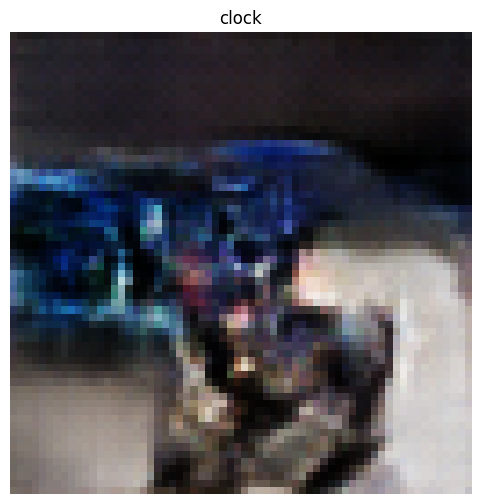

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import save_image

generator.eval()

prompt = "clock"

prompt_inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True)
prompt_inputs = {k: v.to(device) for k, v in prompt_inputs.items()}
with torch.no_grad():
    prompt_embedding = clip_model.get_text_features(**prompt_inputs)

noise = torch.randn(1, noise_dim, device=device)

with torch.no_grad():
    generated_img = generator(noise, prompt_embedding)

generated_img = (generated_img + 1) / 2.0

save_image(generated_img, "generated_image.png")
print("Image saved as generated_image.png")

np_img = generated_img.squeeze(0).permute(1, 2, 0).cpu().numpy()

plt.figure(figsize=(6,6))
plt.imshow(np.clip(np_img, 0, 1))
plt.axis("off")
plt.title(prompt)
plt.show()
